<a href="https://colab.research.google.com/github/michalinahulak/alien_vs_predator_CV/blob/main/alien_vs_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project
The goal of this project is to build a model that can classify images of Aliens and Predators. This is a classic image classification problem, and I used deep learning techniques to tackle it. I used a dataset of images of Aliens and Predators, which was split into a training and testing set. I preprocessed the images. Then, I build a convolutional neural network (CNN) to classify the images. I evaluated model on the testing set and used metrics such as accuracy, precision, recall, and F1-score to measure its performance.

# Imports

In [1]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import opendatasets as od
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping

import requests
import zipfile
import io
import os
import gradio as gr
from PIL import Image
from io import BytesIO
import cv2

from keras.utils import image_dataset_from_directory

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

# Functions

In [4]:
def plot_class_distribution(dataset_path, dataset_name):
    class_names = sorted(os.listdir(dataset_path))
    n_classes = len(class_names)
    class_dis = [len(os.listdir(dataset_path + '/' + name)) for name in class_names]
    fig = px.pie(names=class_names, 
                 values=class_dis, 
                 hole=0.3, 
                 color_discrete_sequence=["#1D3B2F", "#47077F"])
    fig.update_layout(title={'text': f"Class distribution in {dataset_name}", 'x':0.48},
                      width=500,
                      height=500)
    fig.show()

In [5]:
def display_random_images(dataset):
    plt.figure(figsize=(5, 5))
    for images, labels in dataset.take(1):
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

In [6]:
def show_images(dataset):
    images, labels = next(dataset)

    label_names = []
    for label in labels:
        if label[0] == 0 and label[1] == 1:
            label_names.append("predator")
        elif label[0] == 1 and label[1] == 0:
            label_names.append("alien")
        else:
            label_names.append("unknown")

    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(f"{label_names[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def apply_noise(image):
    image = tf.cast(image, tf.float32) / 255.0
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)
    noisy_image = tf.cast(noisy_image * 255, tf.uint8)
    return noisy_image

In [8]:
def flip_image(image):
    flip = tf.random.uniform([], 0, 3, dtype=tf.int32)
    if flip == 0:
        return image
    elif flip == 1:
        return tf.image.flip_left_right(image)
    else:
        return tf.image.flip_up_down(image)

# Upload data

In [7]:
# URL to the .zip file on GitHub
zip_url = 'https://github.com/michalinahulak/alien_vs_predator_CV/raw/main/data.zip'

# Specifying the target directory for extracting the file
target_directory = 'data'  # You can change the target directory path according to your preferences

# Check if the file has already been downloaded and saved
if not os.path.exists(os.path.join(target_directory, 'data.zip')):
    # Downloading the .zip file
    response = requests.get(zip_url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    # Extracting the .zip file
    zip_file.extractall(target_directory)
    zip_file.close()

    print('The .zip file has been downloaded and extracted.')
else:
    print('The .zip file is already downloaded and extracted.')

The .zip file has been downloaded and extracted.


In [8]:
path_train = 'data/data/train'
path_val = 'data/data/validation'

In [9]:
batch_size = 16
img_height = 224
img_width = 224

In [10]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True)

train_ds = data_generator.flow_from_directory(directory=path_train,
                                             target_size=(img_height, img_width),
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=True,
                                             subset = 'training')

val_ds = data_generator.flow_from_directory(path_train,
                                                    target_size = (img_height, img_width),
                                                    batch_size = batch_size, 
                                                    shuffle = True, 
                                                    class_mode = 'categorical',
                                                   subset = 'validation')

test_ds = data_generator.flow_from_directory(directory=path_val,
                                           target_size=(img_height, img_width),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 590 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
class_indices = train_ds.class_indices
print(class_indices)


{'alien': 0, 'predator': 1}


In [ ]:
ds_train = image_dataset_from_directory(
    path_train,
    labels='inferred',
    shuffle=True,
    image_size=(img_height, img_width), 
    seed= 123
)

Found 694 files belonging to 2 classes.


In [ ]:
ds_val = image_dataset_from_directory(
    path_val,
    labels='inferred',
    shuffle=True,
    image_size=(img_height, img_width),
    seed=123
)

Found 200 files belonging to 2 classes.


# EDA

In [ ]:
class_names = ds_train.class_names

In [ ]:
plot_class_distribution(path_train, "ds_train")

In [ ]:
plot_class_distribution(path_val, "ds_val")

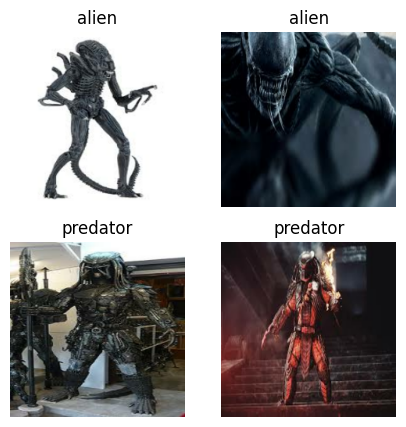

In [ ]:
# Display original pictures
display_random_images(dataset= ds_train)

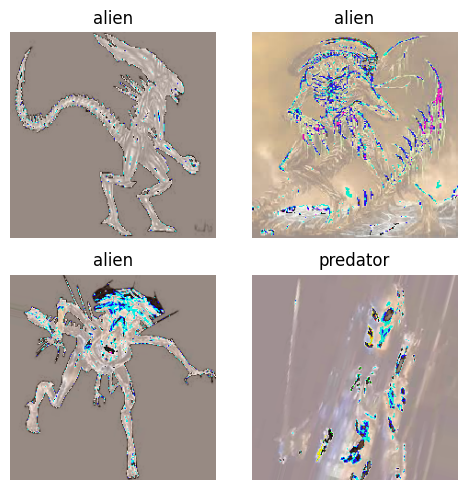

In [ ]:
# Display pictures from data_generator.flow_from_directory
show_images(train_ds)

## RandomContrast

In [ ]:
ds_train_augmented_contrast = ds_train.map(lambda x, y: (preprocessing.RandomContrast(0.5)(tf.image.rgb_to_grayscale(x)), y))

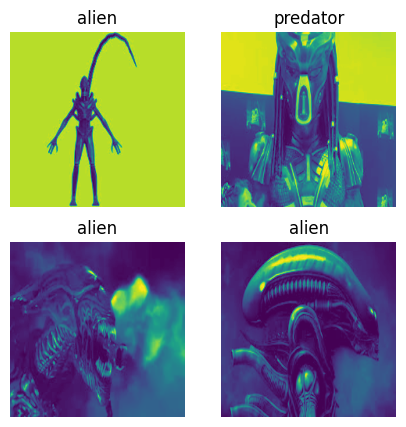

In [ ]:
display_random_images(ds_train_augmented_contrast)

## Grayscale

In [ ]:
ds_train_augmented_gray_rgb = ds_train_augmented_contrast.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

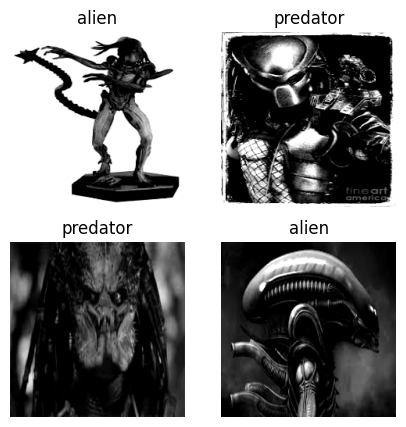

In [ ]:
display_random_images(ds_train_augmented_gray_rgb)

## With noise

In [ ]:
ds_train_noisy = ds_train.map(lambda x, y: (apply_noise(x), y))

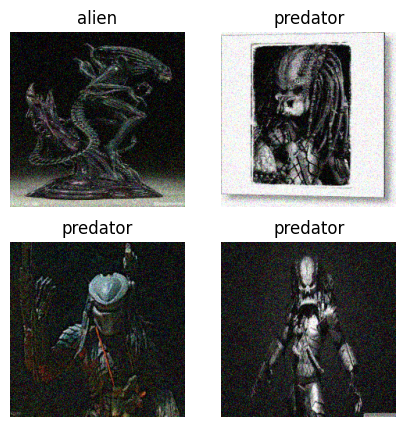

In [ ]:
display_random_images(ds_train_noisy)

## random flip

In [ ]:
ds_train_flipped = ds_train.map(lambda x, y: (flip_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

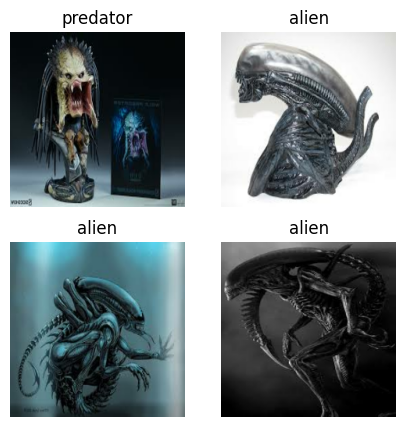

In [ ]:
display_random_images(ds_train_flipped)

# Models

In [ ]:
num_classes = 2
input_shape = (img_height, img_width, 3)

## Convolution neural networks

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),  
  RandomRotation(0.2), 
  RandomZoom(0.2),  
])

In [ ]:
model1 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model3 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model4 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
models = [model1, model2, model3, model4]
histories = []
results = []
early_stopping_monitor = EarlyStopping(patience=2)

for i, model in enumerate(models):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy', 'sparse_categorical_crossentropy'])
    
    history = model.fit(ds_train, epochs=50, callbacks=[early_stopping_monitor], validation_data=ds_val)
    result_val = model.evaluate(ds_val, verbose=0)
    histories.append(history)
    
    result_train = model.evaluate(ds_train, verbose=0)
    
    results.append({'Model_name': f'Model{i+1}',
                    'train_acc': result_train[1], 
                    'train_loss': result_train[0],
                    'val_acc': result_val[1], 
                    'val_loss': result_val[0]
                   })

df_results = pd.DataFrame(results)


In [ ]:
df_results

,Model_name,train_acc,train_loss,val_acc,val_loss
0,Model1,0.672911,0.645593,0.610,0.741953
1,Model2,0.746398,0.538414,0.720,0.557227
2,Model3,0.942363,0.149516,0.715,0.807535
3,Model4,0.727666,0.543392,0.690,0.588158


## Resnet50

In [ ]:
early_stopping_monitor = EarlyStopping(patience=2)
input_shape = (img_height, img_width, 3)
num_classes = 2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping_monitor])

train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)
results = []
results.append({  'train_acc': train_acc, 
                    'train_loss': train_loss,
                     'val_acc': val_acc, 
                    'val_loss': val_loss,
                    'test_acc': test_acc, 
                    'test_loss': test_loss,
                     })
results_resnet = pd.DataFrame(results)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
37/37 [==============================] - 15s 322ms/step - loss: 0.5451 - accuracy: 0.7678 - val_loss: 0.1886 - val_accuracy: 0.9231
Epoch 2/10
37/37 [==============================] - 11s 291ms/step - loss: 0.1519 - accuracy:

In [ ]:
results_resnet

,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss
0,0.967797,0.090449,0.923077,0.184397,0.935,0.177922


In [ ]:
# save model

model.save('models/keras/model.h5')

In [ ]:
# Get the predicted labels and true labels for the test set
y_pred = model.predict(test_ds)
y_true = test_ds.classes

# Get the classification report for each label
report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=['Alien', 'Predator'])

print(report)

13/13 [==============================] - 6s 416ms/step
              precision    recall  f1-score   support

       Alien       0.89      0.93      0.91       100
    Predator       0.93      0.88      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



# Gradio app

In [ ]:
# Load the saved model
# model = tf.keras.models.load_model('model.h5')

# Define the labels
labels = ['Alien', 'Predator']

# Define a function to preprocess the image
def preprocess_image(img):
    # Convert the PIL image to a numpy array
    img_array = np.array(img)
    # Resize the image to the target size of 224x224
    img_array = cv2.resize(img_array, (224, 224))
    # Convert the pixel values to the range of 0-1
    #img_array = img_array / 255.
    # Apply the same preprocessing as in the data generator
    img_array = preprocess_input(img_array)
    # Expand the dimensions of the array to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    # Return the preprocessed image
    return img_array


# Define a function to make predictions on the image
def predict_image(img):
    # Preprocess the image
    img_array = preprocess_image(img)
    # Make a prediction on the preprocessed image
    prediction = model.predict(img_array)
    # Get the index of the predicted class
    predicted_class = np.argmax(prediction)
    # Return the label for the predicted class
    return labels[predicted_class]

# Define the Gradio interface
image_input = gr.inputs.Image()
label_output = gr.outputs.Label()

# Define the Gradio app
gradio_app = gr.Interface(fn=predict_image, inputs=image_input, outputs=label_output, 
                          title='Alien vs Predator Classification', description='Upload an image to classify it as Alien or Predator')

# Run the Gradio app
gradio_app.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8d495c52ee0a32405e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 27ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8d495c52ee0a32405e.gradio.live
